### This Notebook applies the Elmo embedding to a binary siamese network classification model.

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
import os
import smart_open
import collections
import scipy.stats as stats
import tensorflow as tf
import gensim

from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.test.utils import get_tmpfile

import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import Sequential, Model
#from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adadelta, Nadam, Adagrad, Adamax, Ftrl, RMSprop, SGD #schedules
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Conv1D, Conv2D, GlobalAveragePooling1D, Conv2D, ZeroPadding2D
from tensorflow.keras.layers import Bidirectional, GlobalAveragePooling2D, GlobalAveragePooling3D, BatchNormalization, Dropout
from tensorflow.keras.layers import Subtract, Add, Multiply, Activation, Input, Concatenate, Reshape, Dot, GRU, Lambda, Layer 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#import keras as K

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
#from sklearn.model_selection import GridSearchCV, RandomSearch
from sklearn.ensemble import RandomForestClassifier

from sklearn import svm, tree
import xgboost

In [3]:
 path = '/Users/patrickrs/Documents/GitLab/revealapp/10_cleaning/src'

current_path = os.getcwd()
os.chdir(path)
%run ./Load+Clean_News.ipynb
%run ./cont_to_cat_News.ipynb
os.chdir(current_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Get the data

In [4]:
data = news

In [5]:
data

,sim,SimilarityScore,sentence1,sentence2
0,1,4.000,last year wanted murder,last year sought murder
1,1,5.000,promarket economists dont object corporations blatantly use snob appeal promote products,economists companies openly using attractiveness luxury promote products
2,1,5.000,perhaps importantly ahmadinejad destabilizing influence bernanke,perhaps important ahmadinejad destabilising influence bernanke
3,1,4.667,europe,europe
4,1,4.500,gays modern practices rejected selfindulgent,gay practical modern rejected laws
...,...,...,...,...
649,0,1.800,indian pakistani governments nearly engaged fourth conflict 1999,indian pakistani governments conducted nuclear tests may 1998
650,1,3.800,iguaran stated detainees accused homicide criminal collaboration kidnappings funding terrorism,iguaran stated detainees also involved murders police members antikidnapping group
651,1,2.400,3 suspected extremists released bail,1 suspected extremist provisionally released without bail
652,0,0.800,6 czech hospital employees charged human organ trafficking,accused charged international drug trafficking


### Split

In [22]:
y = data['sim']
X = data[['sentence1', 'sentence2']]

In [23]:
# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)
X1_train = X_train['sentence1']
X2_train = X_train['sentence2']
X1_test = X_test['sentence1']
X2_test = X_test['sentence2']

In [24]:
X1_train

0                                                                                                                        last year wanted murder
1                                                       promarket economists dont object corporations blatantly use snob appeal promote products
2                                                                               perhaps importantly ahmadinejad destabilizing influence bernanke
3                                                                                                                                         europe
4                                                                                                   gays modern practices rejected selfindulgent
                                                                         ...                                                                    
518                                                                                                                      myanmar m

In [25]:
X2.shape

(654, 20)

In [11]:
#Learning rate schedule
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True) 

# Elmo Embedding Layer

In [176]:
elmo_layer = hub.KerasLayer("https://tfhub.dev/google/elmo/3", 
                            output_shape=[1024], 
                            input_shape=[None,None], 
                            dtype=tf.string, 
                            trainable=False,
                            name = "elmo_layer")

In [146]:
elmo_layer(tf.convert_to_tensor([['howdy'], 
                                 ['hello']]))

InvalidArgumentError:  input must be a vector, got shape: [2,1]
	 [[node StringSplit/StringSplit (defined at /Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/tensorflow_hub/module_v2.py:95) ]] [Op:__inference_pruned_85593]

Function call stack:
pruned


# Siamese Model

In [172]:
input_1 = Input(shape=[], dtype="string") # input will be one string object plus batch size, hence (1, )
input_2 = Input(shape=[], dtype="string")

embedding1 = elmo_layer(input_1)
embedding2 = elmo_layer(input_2)

conc = Concatenate(axis = -1)([embedding1, embedding2])
x = Dense(300, activation="relu", name='conc_layer')(conc)
x = Dropout(0.2)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)

In [16]:
type(input_1)

tensorflow.python.framework.ops.Tensor

In [174]:
model.compile(loss= "binary_crossentropy", metrics = ['acc'],
              optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=False))

In this network. input_1 and input_2 are pre-processed, Keras-tokenized text sequences which are to be compared for similar intent. These two text sequences are then fed through a common network of a basic embedding layer and an LSTM units. Once the feature vectors are obtained from this common network, a series of similarity measures are computed and are concatenated to be finally input into a Dense layer followed by sigmoid output unit which will finally help in classifying whether the given texts are similar or not.

In [117]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
elmo_layer (KerasLayer)         (None, 1024)         93600852    input_47[0][0]                   
                                                                 input_48[0][0]                   
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 2048)         0           elmo_layer[0][0]           

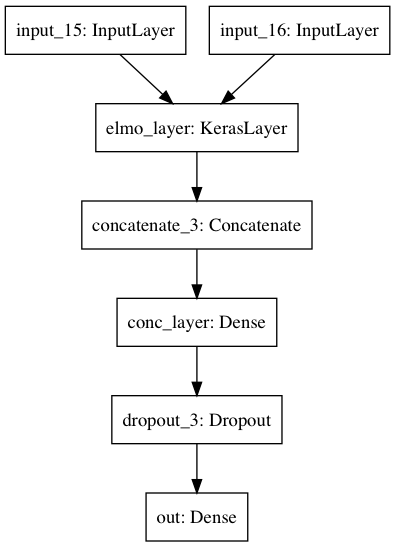

In [68]:
plot_model(model, to_file='model.png', show_shapes=False)

In [69]:
callbacks = [
    keras.callbacks.EarlyStopping(
        restore_best_weights=True,
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=30,
        verbose=1)
            ]

In [175]:
batch = 523
epochs = 1000
history = model.fit([X1_train.values, X2_train.values], y_train, 
                     batch, 
                     epochs = epochs, 
                     callbacks=callbacks,
                     validation_data = ([X1_test.values, X2_test.values], y_test)
                    )

Train on 523 samples, validate on 131 samples
Epoch 1/1000


523/523 [==============================] - 0s 275us/sample


AttributeError: 'NoneType' object has no attribute 'outer_context'

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [169]:
y_test.values

[1, 1, 1, 1, 1, ..., 0, 1, 1, 0, 0]
Length: 131
Categories (2, int64): [0 < 1]

In [ ]:
# GRU better than LSTM? https://www.aclweb.org/anthology/R19-1116.pdf